In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

In [3]:
DIR = "/content/drive/Shareddrives/SI650_Final_Project/ZhihuRec-1M"
CLEANED_DIR = "/content/drive/Shareddrives/SI650_Final_Project/ZhihuRec-1M-Cleaned"

Data Preprocess

In [4]:
ques_df = pd.read_csv(os.path.join(DIR, "question.csv"), index_col=0)

In [ ]:
# # timestamp
# user_df["create_ts_real"] = user_df.create_ts.apply(datetime.fromtimestamp)

# # topic followed
# user_df["topicID_followed"] = user_df["topicID_followed"].apply(
#     lambda x: set(map(int, x.split())) if isinstance(x, str) else x)

# # drop columns
# drop_cols = ['reg_type', 'reg_platform', 'is_android',
#        'is_iphone', 'is_ipad', 'is_pc', 'is_mobile', 'device_model',
#        'device_brand', 'platform', 'province', 'city']
# user_df = user_df.drop(columns=drop_cols)
# user_df.columns

In [ ]:
ques_df

,questionID,create_ts,n_answers,n_followers,n_invitations,n_comments,tokenID,topicID
0,0,1521549457,152,2300,1115,18,3533 227 16 10938 67 229,12585 8177 5022 17842
1,1,1511224941,2402,9045,2313,14,147 65 82 9719 16 98 591 16 620 131,1604
2,2,1361856073,1199,6500,234,90,627 67 231 68 16 82,1682 2743 2 8881
3,3,1514857800,5734,43639,1646,30,248 161 13671 5595 97 247 2860 16 2903,363 11413 719 1578
4,4,1518998398,1459,5262,247,75,1795 872 1047 80 944 26 1046 541 393 1079,3073 325 4 2 5
...,...,...,...,...,...,...,...,...
29335,29335,1502992620,381,700,20,100,166 106 1353 876 13093 16656 1356 864 247 6492...,7666 14791 1553 1777
29336,29336,1519454427,61,177,1601,0,12364 16 6178 1385 67 607 16,515 933 1286 17838 6601
29337,29337,1525356975,12,29,1835,0,766 18 67 68 9463 7106 122 254 7152,NaN
29338,29338,1525149610,7,9,230,0,27221 55 126 13972 21025 1440 28646 150,2667 22896 3497


### Timestamp

In [5]:
from datetime import datetime

In [6]:
ts = ques_df.create_ts.apply(datetime.fromtimestamp)
# Drop invalid records with no timestamp
ques_df = ques_df.drop(ques_df.iloc[ts[ts<"1980-01-01"].index,:].index)
date = ts.apply(datetime.date)

In [7]:
date.apply(lambda x: x.strftime("%Y-%m")).sort_values().value_counts().sort_index()

2010-12       5
2011-01       9
2011-02      12
2011-03      11
2011-04      35
           ... 
2018-01     897
2018-02    1545
2018-03    2327
2018-04    4292
2018-05    6662
Name: create_ts, Length: 90, dtype: int64

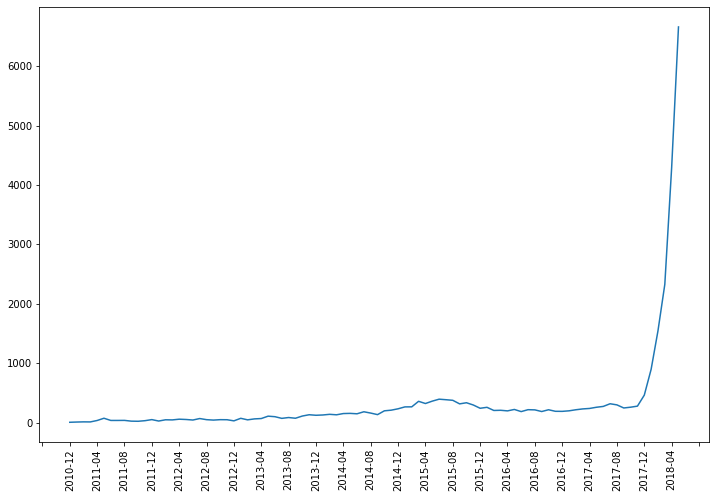

In [9]:
from matplotlib.pyplot import MultipleLocator

plt.figure(figsize=[12,8])
plt.plot(date.apply(lambda x: x.strftime("%Y-%m")).sort_values().unique(), date.apply(lambda x: x.strftime("%Y-%m")).sort_values().value_counts().sort_index())
plt.xticks(rotation=90)
ax=plt.gca()
x_major_locator=MultipleLocator(4)
ax.xaxis.set_major_locator(x_major_locator)

### Basic Features

In [11]:
BASIC_FEATURE = ['n_answers', 'n_followers', 'n_invitations', 'n_comments']

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0.98, 'Distribution of Basic Features of Questions')

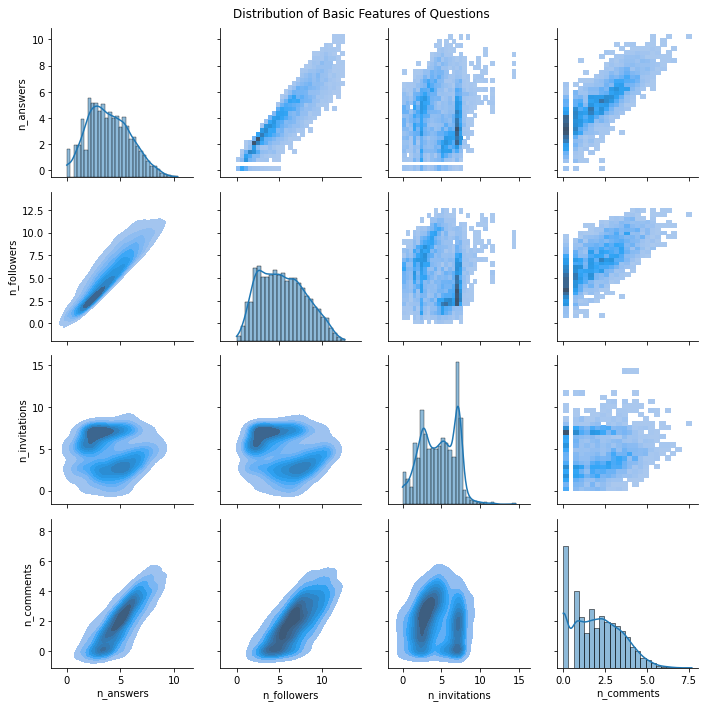

In [12]:
# random sample to save generating time
# use log to rescale the y axis
plot_basic = sns.PairGrid(ques_df[BASIC_FEATURE].apply(lambda x: np.log(x)).sample(frac=0.2, random_state=650)) 
plot_basic.map_upper(sns.histplot)
plot_basic.map_lower(sns.kdeplot, fill=True)
plot_basic.map_diag(sns.histplot, kde=True)

#add overall title
plot_basic.fig.subplots_adjust(top=.95)
plot_basic.fig.suptitle('Distribution of Basic Features of Questions')

### Correlations

In [13]:
# Drop invalid data with no tokenID
ques_df = ques_df.drop(ques_df[ques_df['tokenID'].str.split(' ').str.len().isna() == True].index)

In [14]:
# Add a column to record the number of tokens
ques_df['n_tokens'] = ques_df['tokenID'].str.split(' ').str.len()

In [15]:
cols = ['n_answers', 'n_followers',
       'n_invitations', 'n_comments', 'n_tokens']

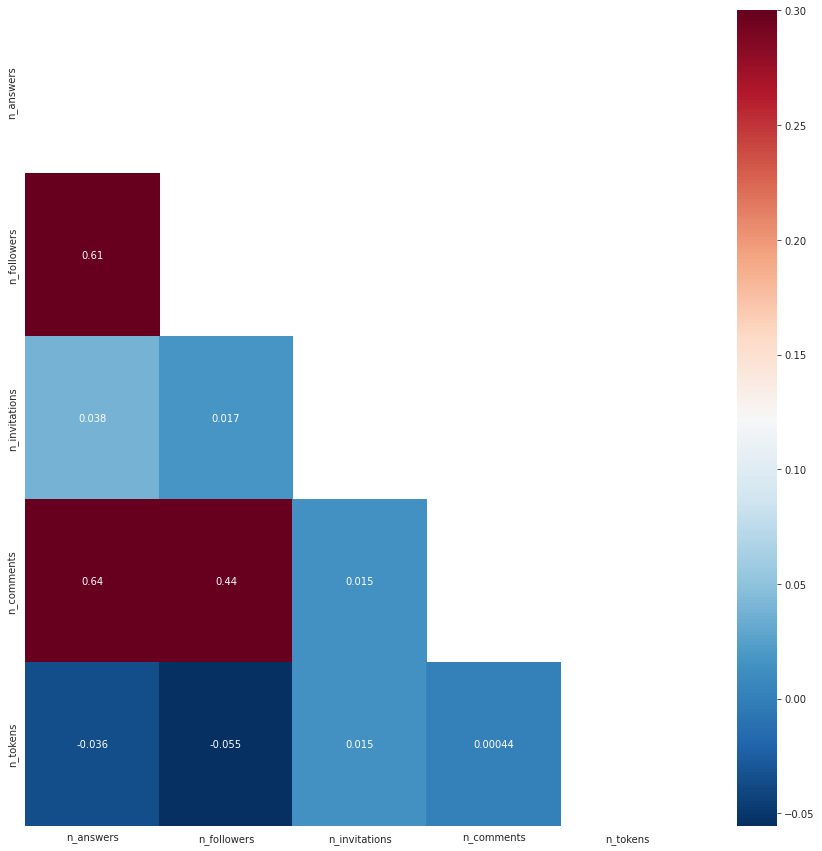

In [16]:
corr = np.corrcoef(ques_df[cols],rowvar=False) 
corr = pd.DataFrame(corr, columns=cols, index=cols)
# Only show the area below the diag
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(15,15))
with sns.axes_style("white"):
    sns.heatmap(corr, mask=mask, vmax=0.3, annot=True,cmap="RdBu_r")

### Topics

In [ ]:
# Number of NAN values
len(ques_df[ques_df['topicID'].str.split(' ').str.len().isna() == True])

5638

In [ ]:
# Drop invalid data with no topicID
ques_df = ques_df.drop(ques_df[ques_df['topicID'].str.split(' ').str.len().isna() == True].index)

In [ ]:
# Add a column to record the number of topics
ques_df['n_topics'] = ques_df['topicID'].str.split(' ').str.len()

In [ ]:
ques_df.n_topics.value_counts()

5     8844
4     4662
3     4332
2     3038
1     2782
6       23
7       11
8        5
11       2
9        1
10       1
Name: n_topics, dtype: int64

In [ ]:
freq_series = ques_df.n_topics.value_counts()

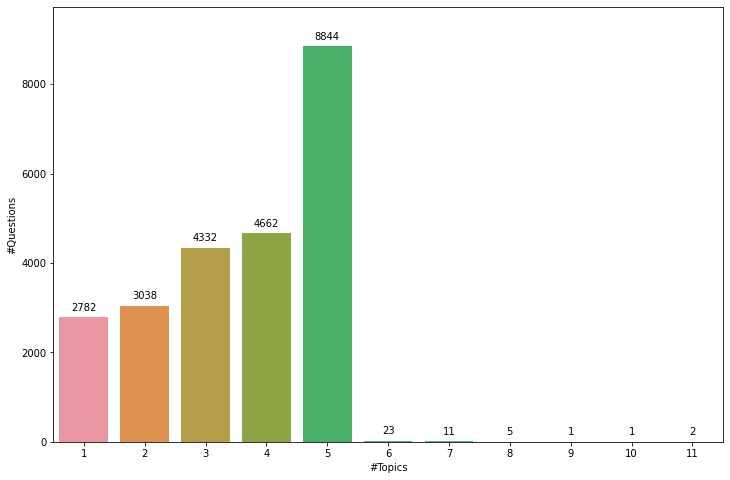

In [ ]:
# plot data
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x=freq_series.index, y=freq_series, ax=ax)

def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.0f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.
add_value_labels(ax)

ax.set_xlabel("#Topics")
ax.set_ylabel("#Questions")

ax.margins(y=0.1)

Text(0, 0.5, '# Questions')

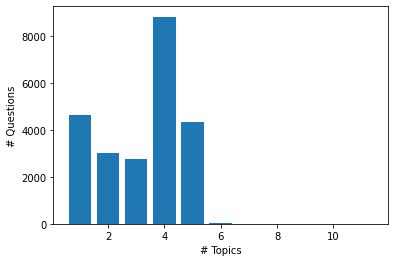

In [ ]:
plt.bar(ques_df.n_topics.unique(), ques_df.n_topics.value_counts())
plt.xlabel("# Topics")
plt.ylabel("# Questions")